In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB

plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
# a density estimator is an algo that seeks to model the probability distribution that generated a dataset. for 1d it is a histogram
def make_data(N, f=0.3, rseed=1):
    # randomly sample from 2 normal distributions
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N) :] += 5
    return x


x = make_data(1000)

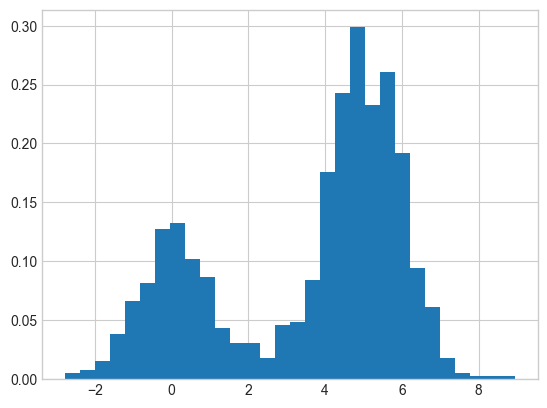

In [3]:
# by specifying the density parameter, we end up with a normalized histogram
hist = plt.hist(x, bins=30, density=True)

In [4]:
# for equal binning this normalization simply changes the scale of the y-axis leabing the relative heights unchanged
# this normilization is chose so that the total area under the histogram is equal to 1 as we can confirm by looking at the output of the histogram function
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

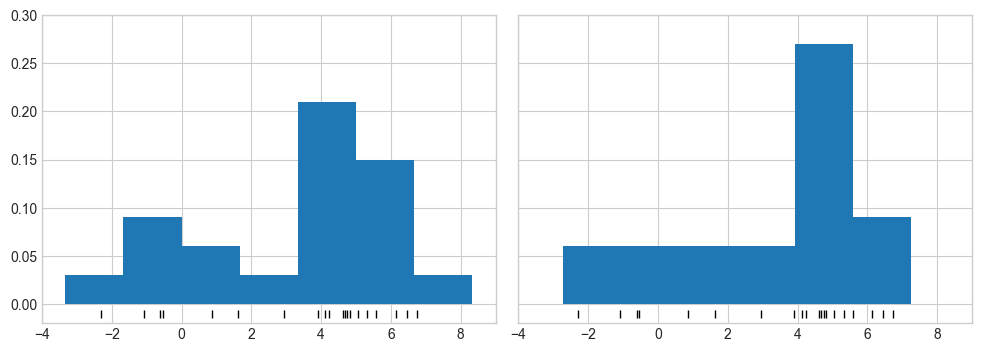

In [5]:
# one of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features for example if we look at a histogram of our data with 10 bins or 25 bins the choice of how to draw the bins can lead to a very different idea of the underlying data distribution
x = make_data(20)
bins = np.linspace(-5, 10, 10)
fig, ax = plt.subplots(
    1,
    2,
    figsize=(12, 4),
    sharex=True,
    sharey=True,
    subplot_kw={"xlim": (-4, 9), "ylim": (-0.02, 0.3)},
)
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), "|k", markeredgewidth=1)

(-0.2, 8.0)

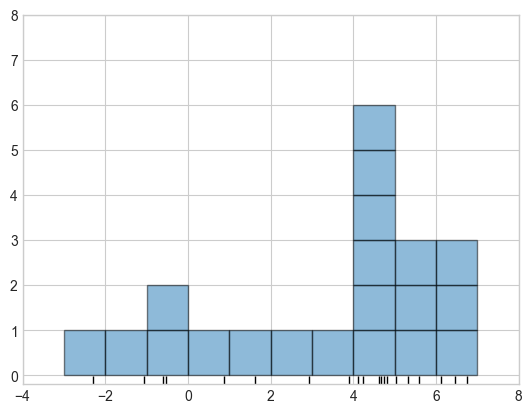

In [6]:
# on the left the histogram makes it clear that this is a bimodal distribution but the right we see a unimodal distribution with a long tail without seeing the preceding data it would be very difficult to understand what the true distribution looks like.
# steppting back we can think of a histogram as a stack of blocks where we stack one block within each bin on top of each point in the dataset. lets see how this works
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), "|k", markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, ec="black", alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

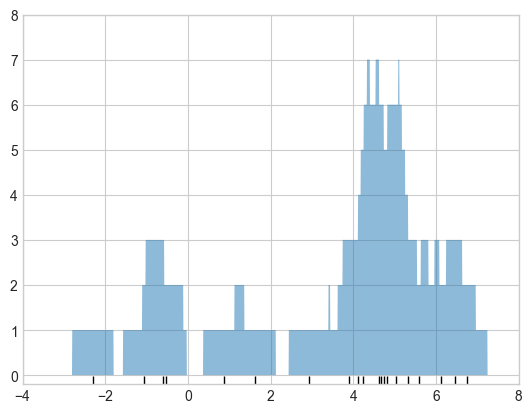

In [7]:
# the problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby but on coincidences of how the bins align with the data points. this misalignment between points and their blocks is a potential cause of the poor histogram results seen here. but what if instead of stacking the blocks aligned with the bins we were to stack the blocks aligned with the points they represent? if we do this, the blocks won't be aligned but we can add their contributions at each location along the x-axis to find the result. lets see how this looks
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), "|k", markeredgewidth=1)
plt.axis([-4, 8, -0.2, 8])

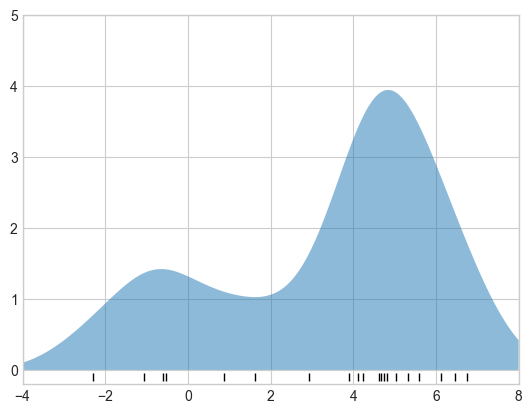

In [8]:
# the results looks a bit messy but it's a much more robust reflection of the actual data characteristics than is the standard histogram. still the rough edges are not aesthetically pleasing nor are they reflective of any true properties of the data. in order to smooth them out we might decide to replace the blocks at each location with a smooth function such as a gaussian. lets use a standard normal curve at each point instead of a block
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), 
# this smoothed out plot with gaussian distribution contributed at the location of each input point gives a much more accurate idea of the shape of the data distribution and one which has much less variance 
# what we have landed on in the last two plots is what's called KDE or kernel density estimation in one dimension. we have placed a kernel -a square or "tophat", shaped kernel in the former a gaussian kernel in the latter- at the location of each point then summed them all to create the smoothed density estimate.

KDE in practice

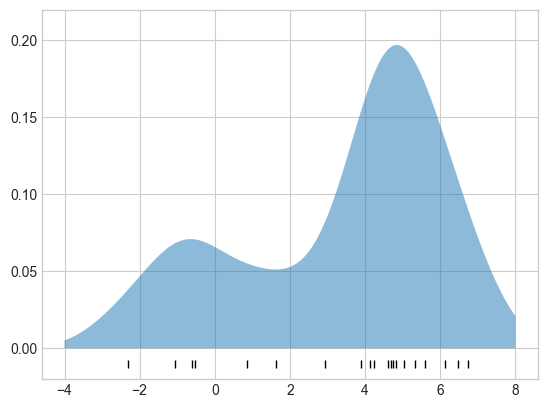

In [11]:
# the free parameters of KDE are the kernel which specifies the shape of the distribution placed at each point and the kernel bandwidth which controls the size of the kernel at each point. in practice there are many kernels you might use for a kernel density estimation. in particular the sklearn KDE implimentation supports six kernels which can be read about in the documentation.
# sklearn's version of KDE is efficient and flexible. it is implemented in the sklearn.neighbors.KernelDensity estimator which handles KDE in multiple dimensions with one of six kernels and one of a couple dozen distance metrics.
# because KDE can be fairly computationally intensive the sklearn KDE estimator uses a tree-based implimentation behind the scenes and can trade off computation time for accuracy using the atol parameter. lets see a quick example of using this to visualize a distribution of points
# lets first show a simple example of replicating the preceding plot using the sklearn.neighbors.KernelDensity estimator

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel="gaussian")
kde.fit(x[:, None])
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), "|k", markeredgewidth=1)
plt.ylim(-0.02, 0.22)
# the result here is normalized such that the area under the curve is equal to 1

In [12]:
# the final estimate produced by a KDE procedure can be quite sensitive to the choices of bandwith which is the knob that controls the bias-variance trade-off in the estimate of density. too narrow a bandwidth leads to a high variance estimate, where the presence or absence of a single point makes a large difference. too wide a bandwith leads to a high bias estimate(underfitting) where the structure in the data is washed out by the wide kernel. one typically finds the right bandwidth using cross-validation as we will see in the following section
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(
    KernelDensity(kernel="gaussian"), {"bandwidth": bandwidths}, cv=LeaveOneOut()
)
grid.fit(x[:, None])

In [13]:
# now we can find the choice of bandwidth that maximizes the score
grid.best_params_

{'bandwidth': 1.1233240329780276}

Example: not so naive bayes

In [14]:
# For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian. With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class. It's still Bayesian classification, but it's no longer naive.
# the general approach for generative classification is this:
# 1. split the training data by label
# 2. for each set, fit a KDE to obtain a generative model of the data. this allows you for any observation x and label y to compute a likelihood P(x|y)
# 3. from the number of examples of each class in the training set, compute the class prior, P(y)
# 4. for an unknown point x, the posterior probability for each class is P(y|x) = P(x|y)P(y). the class that maximizes this posterior is the label assigned to the point
# the algorithm is straightforward and intuitive to understand and implement and in practice it works very well. but there are a few disadvantages:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """

    # each estimator in sklearn is a class and it is most convienient for this class to inherit from the base estimator class as well as the classifier mixin class. for exampl ehere the base estimator contains the logic necessary to clone/copy an estimator for use in a cross-validation procedure and the classifier mixin provides a default implementation of a score method used by such routines. we also provide a docstring for the class which will be used in the online documentation
    def __init__(self, bandwidth=1.0, kernel="gaussian"):
        self.bandwidth = bandwidth
        self.kernel = kernel

    # this is a class initialization method which is the actual code that is executed when the object is instantiated with the KDEClassifier in sk learn it is important that initialization contains no operations other than assigning the passed values by name to self. this is due to the logic contained in base estimator required for cloning and modifying estimators for cross-validation and grid search similarly all arguments to __init__ should be explicit named not *args or **kwargs
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [
            KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi)
            for Xi in training_sets
        ]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self

    # this is where we find the unique classes in the training data and fit a kernel density model for each class and compute the class priors based on the number of input samples. findally fit should always return self so that we can chain commands for example label = model.fit(X, y).predict(X) each persistent result of the fit is stored with a trailing undercore for example self.logpriors_ and self.models_ this is a convention used in scikit-learn so that you can quickly scan the members of an estimator (using IPython's tab completion) and see exactly which members are fit to training data
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(axis=1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

    # this is a probabalistic classifier we first impliment the predict proba which returns an array of class probabilities of shape [n_samples, n_classes]. entry [i, j] of this array is the posterior probability that sample i is a member of class j computed by multiplying the likelihood by the class prior and normalizing. the predict method uses these probabilities and simply returns the class with the largest probability.

In [15]:
# Using our custom estimator
# lets try this on a problem we have seen before the digits classification
digits = load_digits()
grid = GridSearchCV(KDEClassifier(), {"bandwidth": np.logspace(0, 2, 100)})
grid.fit(digits.data, digits.target)

best param: {'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


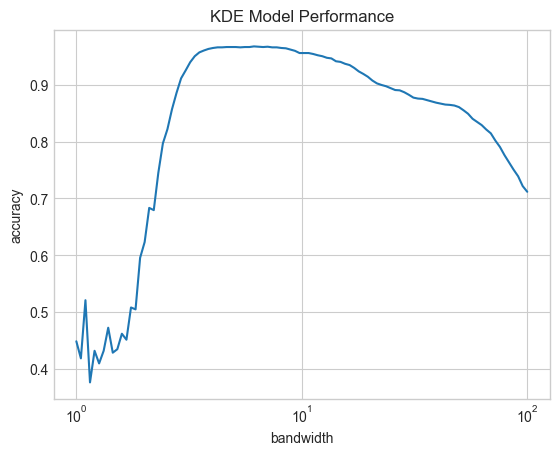

In [16]:
# next we can plot the cross validation score as a function of bandwidth
fig, ax = plt.subplots()
ax.semilogx(
    np.array(grid.cv_results_["param_bandwidth"]), grid.cv_results_["mean_test_score"]
)
ax.set(title="KDE Model Performance", xlabel="bandwidth", ylabel="accuracy")
print(f"best param: {grid.best_params_}")
print(f"accuracy = {grid.best_score_}")
# one benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a full model of the distribution of points we are comparing it to! if desired, this offers an intuitive window into the reasons for a particular classification that algorithms like SVMs and random forests tend to obscure